In [1]:
print("hello")

hello


In [ ]:
NUM_SAMPLES_PER_PROMPT = 30

In [2]:
# ============================================
# 1. セットアップ：ライブラリインストール & インポート
# ============================================

import os
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [3]:
# ============================================
# 2. モデル・トークナイザのロード
# ============================================

# ※環境に合わせてここを書き換えてください
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"  # 例：Qwen2.5-7B-Instruct

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
model.eval()

print("Model loaded:", MODEL_NAME)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded: Qwen/Qwen2.5-7B-Instruct


In [4]:
# ============================================
# 3. ML 研究アイデア用トピック & プロンプト
# ============================================

BASE_INSTRUCTION = """\
You are a machine learning researcher.
Given the following topic, propose ONE concise research idea (2-4 sentences).
Avoid very generic ideas; make it slightly specific but still simple.
Write in English.
"""

topics = [
    "data augmentation for image classification",
    "robustness against adversarial examples",
    "self-supervised learning for time series",
    "efficient fine-tuning methods for large language models",
    "reinforcement learning for recommendation systems",
    "uncertainty estimation in deep neural networks",
    "multi-modal learning with text and images",
    "domain adaptation for medical imaging",
    "continual learning without catastrophic forgetting",
    "explainability methods for black-box models",
]

def build_prompt(topic: str) -> str:
    return BASE_INSTRUCTION + f"\n\nTopic: {topic}\n\nResearch idea:"

prompts = [build_prompt(t) for t in topics]
len(prompts), prompts[0]

(10,
 'You are a machine learning researcher.\nGiven the following topic, propose ONE concise research idea (2-4 sentences).\nAvoid very generic ideas; make it slightly specific but still simple.\nWrite in English.\n\n\nTopic: data augmentation for image classification\n\nResearch idea:')

In [5]:
# ============================================
# 4. 生成 & EOS hidden 抽出関数
# ============================================

@torch.no_grad()
def generate_one_with_eos_hidden(
    prompt: str,
    max_new_tokens: int = 128,
    temperature: float = 1.0,
    top_p: float = 0.95,
) -> Dict[str, Any]:
    """
    1プロンプトに対してテキスト生成し、
    生成後に full_text を再度 forward して EOS hidden を取る。
    """
    # 1) 生成
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    gen_config = GenerationConfig(
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.pad_token_id,
    )
    gen_out = model.generate(
        **inputs,
        generation_config=gen_config,
        return_dict_in_generate=True,
        output_scores=False
    )
    output_ids = gen_out.sequences[0]  # [seq_len]
    full_text = tokenizer.decode(output_ids, skip_special_tokens=True)

    # 2) full_text を forward して hidden_states を取得
    full_inputs = tokenizer(full_text, return_tensors="pt").to(DEVICE)
    out = model(
        **full_inputs,
        output_hidden_states=True,
        return_dict=True,
    )
    hidden_states = out.hidden_states  # Tuple[n_layers+1, B, seq_len, D]
    last_hidden = hidden_states[-1][0]  # [seq_len, D]
    eos_hidden = last_hidden[-1, :].float().cpu()  # [D], float32 にしておく

    return {
        "prompt": prompt,
        "full_text": full_text,
        "output_ids": output_ids.cpu(),
        "eos_hidden": eos_hidden,  # [D]
    }

@torch.no_grad()
def generate_multiple_for_prompt(
    prompt: str,
    num_samples: int = 6,
    max_new_tokens: int = 128,
    temperature: float = 1.0,
    top_p: float = 0.95,
) -> List[Dict[str, Any]]:
    results = []
    for i in range(num_samples):
        res = generate_one_with_eos_hidden(
            prompt,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
        )
        res["sample_idx"] = i
        results.append(res)
    return results

In [ ]:
# ============================================
# 5. 全トピックで生成 & EOS hidden 収集
# ============================================

all_results: List[Dict[str, Any]] = []

for topic, prompt in zip(topics, prompts):
    print(f"=== Generating for topic: {topic} ===")
    topic_results = generate_multiple_for_prompt(
        prompt,
        num_samples=NUM_SAMPLES_PER_PROMPT,
        max_new_tokens=128,
        temperature=1.0,
        top_p=0.95,
    )
    for r in topic_results:
        r["topic"] = topic
    all_results.extend(topic_results)

len(all_results)

=== Generating for topic: data augmentation for image classification ===
=== Generating for topic: robustness against adversarial examples ===
=== Generating for topic: self-supervised learning for time series ===
=== Generating for topic: efficient fine-tuning methods for large language models ===
=== Generating for topic: reinforcement learning for recommendation systems ===
=== Generating for topic: uncertainty estimation in deep neural networks ===
=== Generating for topic: multi-modal learning with text and images ===
=== Generating for topic: domain adaptation for medical imaging ===
=== Generating for topic: continual learning without catastrophic forgetting ===
=== Generating for topic: explainability methods for black-box models ===


60

In [7]:
# ============================================
# 6. テキストの多様性スコア（Jaccard）計算
# ============================================
from itertools import combinations

def jaccard_distance(a_tokens: List[str], b_tokens: List[str]) -> float:
    set_a = set(a_tokens)
    set_b = set(b_tokens)
    inter = len(set_a & set_b)
    union = len(set_a | set_b)
    if union == 0:
        return 0.0
    return 1.0 - inter / union

def diversity_score_for_texts(texts: List[str]) -> float:
    if len(texts) < 2:
        return 0.0
    tokenized = [t.lower().split() for t in texts]
    dists = []
    for i, j in combinations(range(len(texts)), 2):
        dists.append(jaccard_distance(tokenized[i], tokenized[j]))
    return float(np.mean(dists))

topic_to_texts: Dict[str, List[str]] = {}
topic_to_hidden: Dict[str, List[torch.Tensor]] = {}

for r in all_results:
    topic = r["topic"]
    topic_to_texts.setdefault(topic, []).append(r["full_text"])
    topic_to_hidden.setdefault(topic, []).append(r["eos_hidden"])

topic_diversity: Dict[str, float] = {}
for topic, texts in topic_to_texts.items():
    score = diversity_score_for_texts(texts)
    topic_diversity[topic] = score
    print(f"Topic: {topic} | diversity = {score:.3f}")

print("\n=== Sorted by diversity ===")
for t, s in sorted(topic_diversity.items(), key=lambda x: x[1], reverse=True):
    print(f"{s:.3f}  -  {t}")

Topic: data augmentation for image classification | diversity = 0.588
Topic: robustness against adversarial examples | diversity = 0.614
Topic: self-supervised learning for time series | diversity = 0.582
Topic: efficient fine-tuning methods for large language models | diversity = 0.613
Topic: reinforcement learning for recommendation systems | diversity = 0.578
Topic: uncertainty estimation in deep neural networks | diversity = 0.612
Topic: multi-modal learning with text and images | diversity = 0.635
Topic: domain adaptation for medical imaging | diversity = 0.602
Topic: continual learning without catastrophic forgetting | diversity = 0.611
Topic: explainability methods for black-box models | diversity = 0.632

=== Sorted by diversity ===
0.635  -  multi-modal learning with text and images
0.632  -  explainability methods for black-box models
0.614  -  robustness against adversarial examples
0.613  -  efficient fine-tuning methods for large language models
0.612  -  uncertainty estim

In [8]:
# ============================================
# 7. 高多様性トピックの hidden からサブスペース構築
# ============================================

NUM_HIGH = 3
sorted_topics = sorted(topic_diversity.items(), key=lambda x: x[1], reverse=True)
high_topics = [t for t, _ in sorted_topics[:NUM_HIGH]]
print("High diversity topics:", high_topics)

def stack_hidden_for_topics(topics_sel: List[str]) -> torch.Tensor:
    xs = []
    for r in all_results:
        if r["topic"] in topics_sel:
            xs.append(r["eos_hidden"])
    return torch.stack(xs, dim=0)  # [N, D]

high_hidden = stack_hidden_for_topics(high_topics)
print("High hidden shape:", high_hidden.shape)

SUBSPACE_DIM = 8  # 好きに変更OK

def build_diversity_subspace(
    high_hidden: torch.Tensor,
    subspace_dim: int = SUBSPACE_DIM,
) -> Dict[str, Any]:
    h_np = high_hidden.numpy()  # [N, D]
    pca = PCA(n_components=subspace_dim)
    pca.fit(h_np)
    basis = pca.components_.astype(np.float32)  # [k, D]
    basis_t = torch.from_numpy(basis)          # [k, D]
    explained = pca.explained_variance_ratio_.sum()
    print(f"Subspace dim={subspace_dim}, explained variance sum={explained:.4f}")
    return {
        "basis": basis_t,
        "pca": pca,
    }

subspace_info = build_diversity_subspace(high_hidden, SUBSPACE_DIM)
div_basis = subspace_info["basis"]  # [k, D]
div_basis.shape

High diversity topics: ['multi-modal learning with text and images', 'explainability methods for black-box models', 'robustness against adversarial examples']
High hidden shape: torch.Size([18, 3584])
Subspace dim=8, explained variance sum=0.9162


torch.Size([8, 3584])

In [9]:
# ============================================
# 8. サブスペースモデル定義（投影・ノルムなど）
# ============================================

class DiversitySubspaceModel:
    """
    Representation Diversity Subspace:
    - basis: [k, D]
    - project: h -> z
    - norm: トークンごとの内部「強さ」を測る
    """
    def __init__(self, basis: torch.Tensor):
        self.basis = basis.to(torch.float32)  # [k, D]
        self.k, self.D = self.basis.shape
    
    def project(self, h: torch.Tensor) -> torch.Tensor:
        """
        h: [..., D]
        return: [..., k]
        """
        if h.dtype != self.basis.dtype:
            h = h.to(self.basis.dtype)
        assert h.shape[-1] == self.D, f"dim mismatch: {h.shape[-1]} vs {self.D}"
        orig_shape = h.shape[:-1]
        h_flat = h.reshape(-1, self.D)  # [N, D]
        z_flat = h_flat @ self.basis.t()  # [N, k]
        z = z_flat.reshape(*orig_shape, self.k)
        return z
    
    def norm(self, h: torch.Tensor) -> torch.Tensor:
        """
        射影ノルムを返す。
        h: [..., D]
        return: [...], サブスペース上の L2 ノルム
        """
        z = self.project(h)  # [..., k]
        return torch.linalg.norm(z, dim=-1)

div_model = DiversitySubspaceModel(div_basis)
print("DiversitySubspaceModel ready. k =", div_model.k, "D =", div_model.D)

DiversitySubspaceModel ready. k = 8 D = 3584


In [10]:
# ============================================
# 9. 1つのプロンプトについて、各ステップ hidden を取得
# ============================================

@torch.no_grad()
def generate_full_with_hidden(
    prompt: str,
    max_new_tokens: int = 128,
    temperature: float = 1.0,
    top_p: float = 0.95,
) -> Dict[str, Any]:
    """
    1プロンプトに対して生成を行い、その full_text を forward して
    全トークン位置・全層の hidden を取得する。
    """
    # 1) generate
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    gen_config = GenerationConfig(
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.pad_token_id,
    )
    gen_out = model.generate(
        **inputs,
        generation_config=gen_config,
        return_dict_in_generate=True,
        output_scores=False
    )
    output_ids = gen_out.sequences[0]  # [seq_len]
    full_text = tokenizer.decode(output_ids, skip_special_tokens=True)

    # 2) full_text を forward
    full_inputs = tokenizer(full_text, return_tensors="pt").to(DEVICE)
    out = model(
        **full_inputs,
        output_hidden_states=True,
        return_dict=True,
    )
    hidden_states = out.hidden_states  # Tuple[n_layers+1, B, seq_len, D]
    # テンソルにまとめる: [L+1, seq_len, D]
    hs = torch.stack([h[0].float().cpu() for h in hidden_states], dim=0)

    return {
        "prompt": prompt,
        "full_text": full_text,
        "output_ids": output_ids.cpu(),
        "hidden_per_layer": hs,  # [num_layers+1, seq_len, D]
    }

# 例として、high_topics の最初のトピックで 1サンプル生成
test_topic = high_topics[0]
test_prompt = build_prompt(test_topic)
print("Test topic:", test_topic)
print("Prompt:\n", test_prompt)

gen_detail = generate_full_with_hidden(test_prompt, max_new_tokens=128)
print("\nGenerated text:\n", gen_detail["full_text"])
print("hidden_per_layer shape:", gen_detail["hidden_per_layer"].shape)

Test topic: multi-modal learning with text and images
Prompt:
 You are a machine learning researcher.
Given the following topic, propose ONE concise research idea (2-4 sentences).
Avoid very generic ideas; make it slightly specific but still simple.
Write in English.


Topic: multi-modal learning with text and images

Research idea:

Generated text:
 You are a machine learning researcher.
Given the following topic, propose ONE concise research idea (2-4 sentences).
Avoid very generic ideas; make it slightly specific but still simple.
Write in English.


Topic: multi-modal learning with text and images

Research idea: 
Exploring the effectiveness of contrastive learning techniques in aligning textual and visual representations for improved cross-modal retrieval in scenarios with limited labeled data. To enhance cross-modal retrieval, particularly in resource-constrained settings, this study will investigate how contrastive learning techniques can effectively align textual and visual emb

In [11]:
# ============================================
# 10. 最終層 hidden についてトークンごとのサブスペースノルムを計算
# ============================================

hidden_per_layer = gen_detail["hidden_per_layer"]  # [L+1, T, D]
num_layers_plus1, T, D = hidden_per_layer.shape
print("num_layers+1:", num_layers_plus1, "| seq_len:", T, "| hidden_dim:", D)

# 最終層（最後の index）の hidden: [T, D]
last_layer_hidden = hidden_per_layer[-1]  # [T, D]

# サブスペースノルム: [T]
token_norms = div_model.norm(last_layer_hidden)  # [T]

# トークン列も取っておく
token_ids = gen_detail["output_ids"]  # [T]
tokens = tokenizer.convert_ids_to_tokens(token_ids.tolist())

for i in range(T):
    print(f"{i:02d}  token={tokens[i]!r:<15}  norm={token_norms[i].item():.4f}")

num_layers+1: 29 | seq_len: 149 | hidden_dim: 3584
00  token='You'            norm=187.1656
01  token='Ġare'           norm=210.2226
02  token='Ġa'             norm=201.2619
03  token='Ġmachine'       norm=163.0376
04  token='Ġlearning'      norm=149.2533
05  token='Ġresearcher'    norm=169.9202
06  token='.Ċ'             norm=31.7220
07  token='Given'          norm=129.6743
08  token='Ġthe'           norm=171.2758
09  token='Ġfollowing'     norm=139.8511
10  token='Ġtopic'         norm=77.7329
11  token=','              norm=115.6178
12  token='Ġpropose'       norm=134.8026
13  token='ĠONE'           norm=106.1957
14  token='Ġconcise'       norm=78.3284
15  token='Ġresearch'      norm=119.4114
16  token='Ġidea'          norm=85.0378
17  token='Ġ('             norm=46.1920
18  token='2'              norm=117.7612
19  token='-'              norm=36.0918
20  token='4'              norm=114.5827
21  token='Ġsentences'     norm=132.2873
22  token=').Ċ'            norm=48.5804
23  token='Av

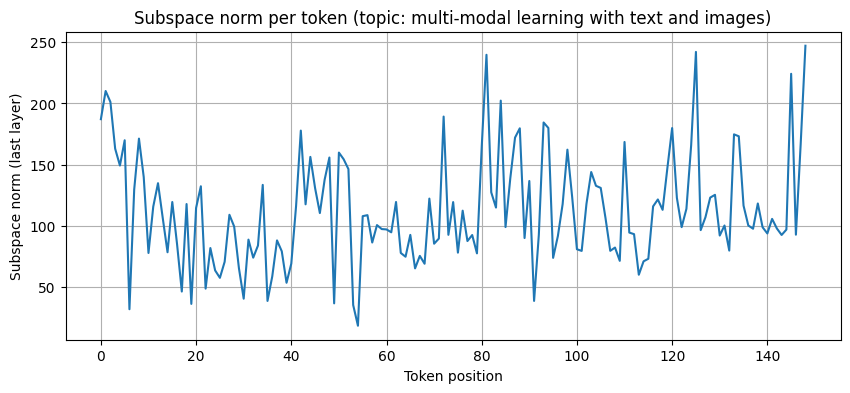

In [12]:
# ============================================
# 11. トークン位置 vs サブスペースノルムの可視化
# ============================================

plt.figure(figsize=(10, 4))
plt.plot(range(T), token_norms.numpy())
plt.xlabel("Token position")
plt.ylabel("Subspace norm (last layer)")
plt.title(f"Subspace norm per token (topic: {test_topic})")
plt.grid(True)
plt.show()

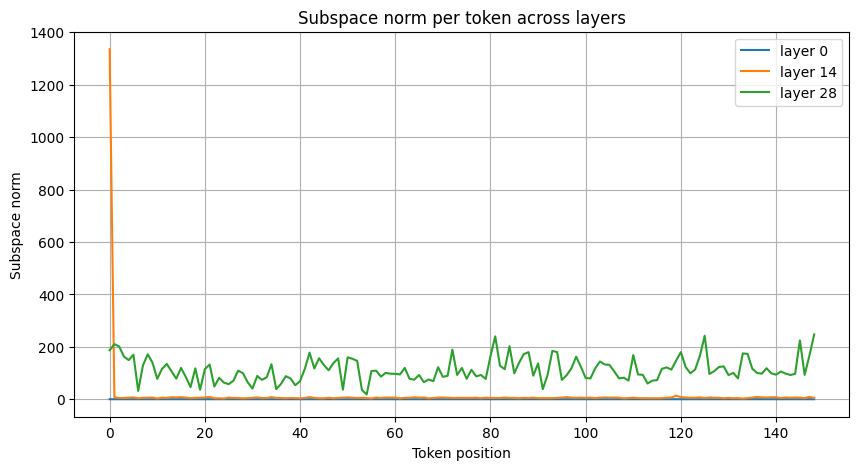

In [13]:
# ============================================
# 12. 複数の層でトークンごとのノルムを比較（オプション）
# ============================================

layer_indices = [0, num_layers_plus1 // 2, num_layers_plus1 - 1]  # 入力埋め込み層 / 中間 / 最終層 など
layer_labels = []

plt.figure(figsize=(10, 5))

for idx in layer_indices:
    h_layer = hidden_per_layer[idx]  # [T, D]
    norms_layer = div_model.norm(h_layer)  # [T]
    plt.plot(range(T), norms_layer.numpy())
    layer_labels.append(f"layer {idx}")

plt.xlabel("Token position")
plt.ylabel("Subspace norm")
plt.title("Subspace norm per token across layers")
plt.grid(True)
plt.legend(layer_labels)

In [15]:
# ============================================
# サブスペース基底 div_basis を保存するセル
# ============================================

import torch

# すでに作ってあるはずの div_basis を確認
print("div_basis shape:", div_basis.shape)  # 例: torch.Size([8, 3584])

# 念のため dtype をそろえておく（float32 に統一）
basis_to_save = div_basis.to(torch.float32).cpu()

save_path = "div_basis.pt"
torch.save(basis_to_save, save_path)

print(f"Saved diversity subspace basis to: {save_path}")

div_basis shape: torch.Size([8, 3584])
Saved diversity subspace basis to: div_basis.pt
